## Tutorial for using SMOPCA on Stereo-CITE-seq Mouse Thymus1 dataset
Import modules.

In [5]:
import logging
import h5py
import numpy as np
import pandas as pd
import scanpy as sc
import warnings
from SMOPCA.utils import preprocess_adata
from SMOPCA.model import SMOPCA
from sklearn.cluster import KMeans

for handler in logging.root.handlers[:]:  # avoid DEBUG level information in jupyter notebook
    logging.root.removeHandler(handler)
logging.basicConfig(level=logging.INFO)  # use DEBUG for verbose information
warnings.filterwarnings('ignore')


Load and check dataset.

In [6]:
adata1 = sc.read_h5ad(f'./data/Mouse_Thymus1_adata_RNA.h5ad')
adata2 = sc.read_h5ad(f'./data/Mouse_Thymus1_adata_ADT.h5ad')
X1, X2, pos = preprocess_adata([adata1, adata2])
print(X1.shape, X2.shape, pos.shape)

(4510, 2000) (4510, 51) (4510, 2)


Build the SMOPCA model and inference parameters.

In [7]:
smopca = SMOPCA(Y_list=[X1.T, X2.T], Z_dim=20, pos=pos, intercept=False)
smopca.estimateParams(sigma_init_list=(1, 1), tol_sigma=2e-5, sigma_xtol_list=(1e-6, 1e-6), gamma_init=5, estimate_gamma=True, gamma_tol=1)
z = smopca.calculatePosterior()
y_pred = KMeans(n_clusters=8, n_init=100).fit_predict(z)

INFO:src.SMOPCA:SMOPCA object created, with 4510 cells and [2000, 51] features and matern kernel
INFO:src.SMOPCA:start estimating parameters, this will take a while...
INFO:src.SMOPCA:calculating matern kernel, nu = 1.5, length_scale = 5
INFO:src.SMOPCA:estimating sigma1
INFO:src.SMOPCA:sigma1 using bound: (0.90000, 1.00000)
INFO:src.SMOPCA:iter 0 sigma1 brentq done, sigma1sqr = 1.00000, sigma1hatsqr = 0.96110
INFO:src.SMOPCA:iter 1 sigma1 brentq done, sigma1sqr = 0.96110, sigma1hatsqr = 0.96110
INFO:src.SMOPCA:reach tolerance threshold, sigma1 done!
INFO:src.SMOPCA:estimating sigma2
INFO:src.SMOPCA:sigma2 using bound: (0.60000, 0.70000)
INFO:src.SMOPCA:iter 0 sigma2 brentq done, sigma2sqr = 1.00000, sigma2hatsqr = 0.68715
INFO:src.SMOPCA:iter 1 sigma2 brentq done, sigma2sqr = 0.68715, sigma2hatsqr = 0.68715
INFO:src.SMOPCA:reach tolerance threshold, sigma2 done!
INFO:src.SMOPCA:iter 0 gamma minimize done, gamma = 5.00000, gamma_hat = 9.44829
INFO:src.SMOPCA:calculating matern kernel, 

Visualize the inferred spatial domain.

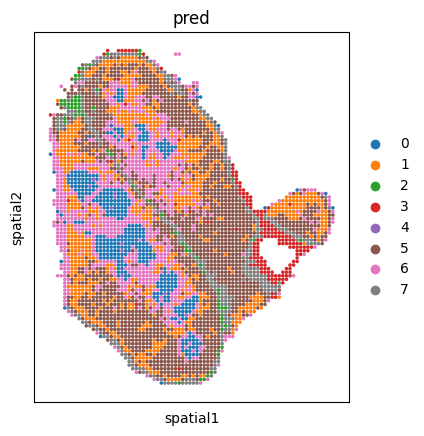

In [21]:
adata_res = sc.AnnData(z)
adata_res.obsm['spatial'] = pos
adata_res.obs['pred'] = pd.Categorical(y_pred)
sc.pl.spatial(adata_res, color='pred', spot_size=100)

Visualize the latent space using UMAP.

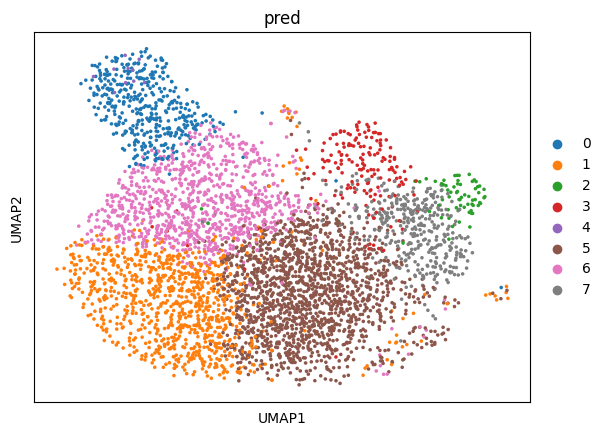

In [22]:
sc.pp.neighbors(adata_res, n_neighbors=100, use_rep='X', metric='euclidean')
sc.tl.umap(adata_res, min_dist=1)
sc.pl.umap(adata_res, color='pred')

## Perform Differential Expression Analysis
Find marker gene for each cluster using FindMarkers.

In [ ]:
library(rhdf5)
library(dplyr)
library(Seurat)
library(Matrix)
library(patchwork)
library(pheatmap)
for (feat_type in c('gene', 'protein')) {
    h5_file <- H5Fopen(paste0("./data/Mouse_Thymus1_filtered.h5"))
    cell <- as.matrix(h5_file$cell)  # 2491
    if (feat_type == 'gene') {
        X <- as(h5_file$raw_gene_count, "sparseMatrix")
        gene <- as.matrix(h5_file$gene)
        rownames(X) <- gene
    } else {
        X <- as(h5_file$raw_protein_count, "sparseMatrix")
        protein <- as.matrix(h5_file$protein)
        rownames(X) <- protein
    }
    h5closeAll()
    colnames(X) <- cell
    y_pred <- as.matrix(read.csv("./data/smopca_pred_label.csv", row.names=1))
    seu <- CreateSeuratObject(counts = X, project = "diff_expr", min.cells = 0, min.features = 0)
    seu <- NormalizeData(seu, normalization.method = "LogNormalize", scale.factor = 10000)
    Idents(seu) <- y_pred
    y_unique <- c('0', '1', '2', '3', '4', '5', '6')
    res_folder <- "./res/" 
    for (g in y_unique) {
        de.markers <- FindMarkers(seu, ident.1 = g, ident.2 = NULL, only.pos = F)
        write.csv(de.markers, file=paste0(res_folder, paste0("cluster-", g, "-de-", feat_type, ".csv")))
    }
}
}

Select marker genes and perpare expression data for visualization.

In [1]:
import numpy as np
import pandas as pd

top_feat_num = 10  # top gene num of each cluster
cluster_list = [0, 1, 2, 3, 4, 5, 6, 7]
y_pred = pd.read_csv("./data/smopca_pred_label.csv", index_col=0).values.flatten()

for feat_type in ['gene', 'protein']:
    de_csv_list = []
    cluster_gene_dict = {}
    top_gene_list = []
    all_top_gene_list = []
    normed_df = pd.read_csv(f"./data/normed_{feat_type}_mat.csv", index_col=0)  # heatmap needs normalized raw data
    # print("checking raw data shape:", normed_df.shape, y_pred.shape)

    # find markers for each cluster
    for i in cluster_list:
        de_csv_i = pd.read_csv(f"./res/cluster-{i}-de-{feat_type}.csv", index_col=0)  # print this to see the sorted p values and genes
        # all_top_gene_list += list(de_csv_i.index[de_csv_i['p_val_adj'] < 0.05])
        # continue
        de_csv_list.append(de_csv_i)
        count = j = 0  # j for the current gene index
        while count < top_feat_num:
            if de_csv_i.index[j] in top_gene_list:
                # print(f"gene {de_csv_i.index[j]} already exist in {top_gene_list}, continue")
                j += 1
                continue
            if de_csv_i['p_val_adj'].iloc[j] > 0.05:
                # print(f"gene {de_csv_i.index[j]} p_val > 0.05, stop finding")
                break
            top_gene_list.append(de_csv_i.index[j])
            count += 1
            j += 1
        # print("cluster", i, de_csv_i.iloc[:j], end='\n\n')

    # find the subset expr matrix of interest
    data_list = []
    for top_gene in top_gene_list:
        expr_cluster_list = []
        expr_dat = np.array(normed_df.loc[top_gene])
        for i in cluster_list:
            expr_cluster = expr_dat[y_pred == i]
            expr_cluster_list.append(np.mean(expr_cluster))
        data_list.append(expr_cluster_list)
    data_mat = np.array(data_list)
    # print(data_mat.shape)
    data_df = pd.DataFrame(data=data_mat, index=top_gene_list, columns=[f'cluster_{i}' for i in cluster_list])
    # data_df = pd.DataFrame(data=data_mat.T, columns=top_gene_list, index=[f'cluster_{i}' for i in cluster_list])

    # change gene and protein names for plotting
    if feat_type == 'gene':
        new_ind = []
        for gene_name in data_df.index:
            if gene_name.count('.') == 0:
                new_ind.append(gene_name)
            else:
                new_gene_name = gene_name.replace('.', '-')
                new_ind.append(new_gene_name)
        data_df.index = new_ind
    elif feat_type == 'protein':
        new_ind = []
        for protein_name in data_df.index:
            if protein_name.count('human-mouse.Mac.2..Galectin.3') == 1:
                new_ind.append('Mac2')
            else:
                # new_ind.append(protein_name)
                new_ind.append(protein_name.split('.')[0])
        data_df.index = new_ind
    print(data_df)
    data_df.to_csv(f"./res/{feat_type}_dat_top={top_feat_num}.csv")

        cluster_0  cluster_1  cluster_2  cluster_3  cluster_4  cluster_5  \
Fscn1    1.509689  -0.190807  -0.170747  -0.054342   3.763929  -0.190629   
Fcgbp    1.507249  -0.184203   0.053794  -0.155765   3.162336  -0.193747   
Krt5     1.557102  -0.214685   0.028330  -0.245042   2.554560  -0.221457   
Csn2     1.407385  -0.157235  -0.168600  -0.124694   1.506627  -0.163672   
H2-K1    1.847088  -0.360810   0.197649  -0.214400   2.226267  -0.370663   
...           ...        ...        ...        ...        ...        ...   
Pltp    -0.163044  -0.195512   0.808299   0.215301  -0.406531  -0.012424   
Ctsl     0.009056  -0.312814   0.362234  -0.263134  -0.599020  -0.000162   
Snhg11  -0.085105  -0.148682   0.361068   0.057533  -0.224066  -0.060387   
Hspa8    0.291912  -0.323534   0.890426   0.264068   1.083691  -0.030682   
Thy1    -0.601384  -0.004899   0.501562  -0.293479  -0.481433   0.081260   

        cluster_6  cluster_7  
Fscn1   -0.120785  -0.111927  
Fcgbp   -0.099330  -0.147

Visualize the marker genes and proteins with heatmap.

       Fscn1      Fcgbp       Krt5       Csn2      H2-K1       Gpx3       Aire
0  0.6726791  0.8298683  1.0849101  1.5516398  1.3809530  1.2025332  1.4002912
1 -0.5246187 -0.5538830 -0.6029972 -0.5570137 -0.8070697 -0.7278328 -0.5375723
2 -0.5104949 -0.3591810 -0.3714870 -0.5723297 -0.2536371  0.2117391 -0.5748703
3 -0.4285356 -0.5306186 -0.6319173 -0.5131578 -0.6619776 -0.6514582 -0.5748703
4  2.2598614  2.1838703  2.0351462  1.6853897  1.7567188  1.8306826  1.8169135
5 -0.5244939 -0.5616911 -0.6094494 -0.5656886 -0.8168333 -0.7715450 -0.5551077
6 -0.4753172 -0.4844502 -0.4524147 -0.4874035 -0.3577700 -0.6167499 -0.4382617
7 -0.4690803 -0.5239147 -0.4517906 -0.5414362 -0.2403840 -0.4773690 -0.5365225
       Ccl22     Syngr2       Ccr7      Lars2     Filip1l      Camk1d
0  1.4215584  1.2165607  1.8481816  0.1361965  0.16878471  0.41949671
1 -0.5432302 -0.5689951 -0.4733264  1.1103804  1.24437408  1.23137327
2 -0.5794310 -0.5274859 -0.5320329 -0.8700466 -0.71080606 -0.67575686
3 -0.5794

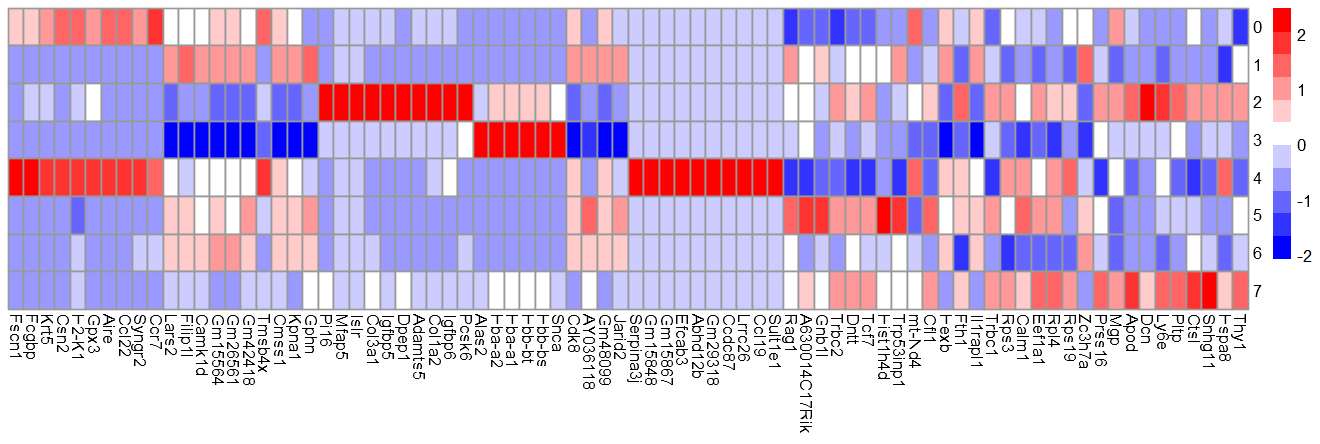

In [3]:
library(pheatmap)
myplot <- function(
	dat, ann, ann_color=NA, n.col=11, c_col=T, c_row=F, show_rownames=T, show_colnames=T, 
	breaks=seq(from=-max(abs(dat)), to=max(abs(dat)), len=n.col + 1), fontsize = 10
) {
	print(dat)
	pheatmap(
		dat, color = colorRampPalette(c("blue", "white", "red"))(n.col), clustering_distance_rows = "correlation",  clustering_distance_cols = "correlation",  clustering_method = "complete",
		cluster_cols = c_col, cluster_rows = c_row, fontsize = fontsize
	)
}

top_gene_num = 10
feat_type = 'gene'
dat_ = read.csv(paste0("./res/", feat_type, "_dat_top=", top_gene_num, ".csv"), row.names=1)
dat_ = t(scale(t(dat_), center = TRUE, scale = TRUE))
dat_[dat_ > 4] = 4
dat_[dat_ < -4] = -4

colnames(dat_)=c("0","1","2","3","4","5","6","7")

s=rownames(dat_)
for(i in 1:length(s)){
  if(substr(s[i],1,15)=="mouse_rat_human"){
    s[i]=substr(s[i],17,nchar(s[i]))
  }
  if(substr(s[i],1,11)=="mouse_human"){
   s[i]=substr(s[i],13,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Human"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,3)=="Rat"){
   s[i]=substr(s[i],5,nchar(s[i]))
  }  
}
rownames(dat_)=s
fontsize = 10
#pdf(paste0("./fig/", feat_type, "_fontsize=", fontsize, "_top=", top_gene_num, ".pdf"),width=11, height=3.7)
options(repr.plot.width=11,repr.plot.height=3.7)
myplot(t(dat_), ann=NA, ann_color=NA, c_col=F, c_row=F, show_colnames=F, show_rownames=T, fontsize=fontsize)#, breaks=break_ )
dev.off()
tt=t(dat_)


        CD8a        CD3       CD19       CD68          CD29        CD4
0 -1.3426628  0.4510141 -0.1554956  1.4907349  0.1296699424  0.2662347
1  0.7904779 -1.3069716 -1.2772850  0.3205330 -1.1086647755  0.8505565
2 -0.2124299  0.8322109  1.1947801 -1.2941820  1.3221434837 -2.0000525
3  0.5488712  0.5981296  1.2782170 -0.9499563  0.4528565195 -0.4899112
4 -1.6229487  1.3199138  0.3626229  0.7548818 -0.0007501652  0.6400963
5  1.1550727 -1.2470215 -1.1248812 -0.2115931 -1.1805432373  0.8519654
6  0.2318284 -0.8390791 -0.7899562  0.8041306 -0.8874020157  0.5819657
7  0.4517912  0.1918038  0.5119981 -0.9145489  1.2726902481 -0.7008549
         IgD      IgG2b       F480 CD45R_B220      IgG2a       CD38      CD169
0 -0.2974561 -0.3979774 -0.4111683 -0.5088754 -0.5627842 -0.5159008 -0.1942628
1 -1.0291840 -1.0653373 -1.0314545 -1.0261847 -0.9636932 -0.9647722 -1.0031651
2  1.5399985  1.3233242  1.4121958  1.5329754  1.4422734  1.4531279  1.6072291
3  1.2354192  1.4024799  1.3215139  1.0210693

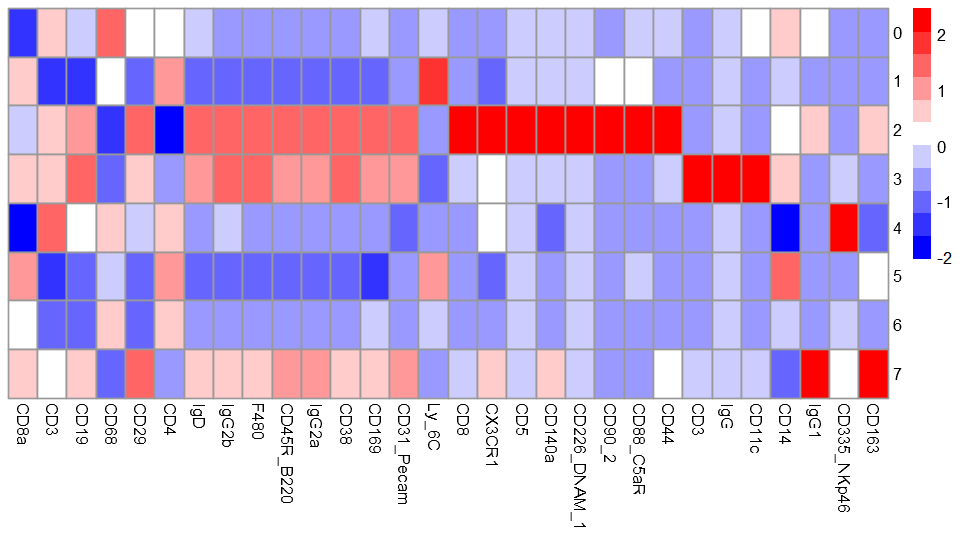

In [8]:
feat_type = 'protein'
dat_ = read.csv(paste0("./res/", feat_type, "_dat_top=", top_gene_num, ".csv"), row.names=1)
dat_ = t(scale(t(dat_), center = TRUE, scale = TRUE))
dat_[dat_ > 4] = 4
dat_[dat_ < -4] = -4

colnames(dat_)=c("0","1","2","3","4","5","6","7")

s=rownames(dat_)
for(i in 1:length(s)){
  if(substr(s[i],1,15)=="mouse_rat_human"){
    s[i]=substr(s[i],17,nchar(s[i]))
  }
  if(substr(s[i],1,11)=="mouse_human"){
   s[i]=substr(s[i],13,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Mouse"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,5)=="Human"){
    s[i]=substr(s[i],7,nchar(s[i]))
  }
  if(substr(s[i],1,3)=="Rat"){
   s[i]=substr(s[i],5,nchar(s[i]))
  }  
}
rownames(dat_)=s
fontsize = 10
#pdf(paste0("./fig/", feat_type, "_fontsize=", fontsize, "_top=", top_gene_num, ".pdf"),width=11, height=3.7)
options(repr.plot.width=8,repr.plot.height=4.5)
myplot(t(dat_), ann=NA, ann_color=NA, c_col=F, c_row=F, show_colnames=F, show_rownames=T, fontsize=fontsize)#, breaks=break_ )
dev.off()
tt=t(dat_)


Visualzie the spatial expression distribution of selected proteins.

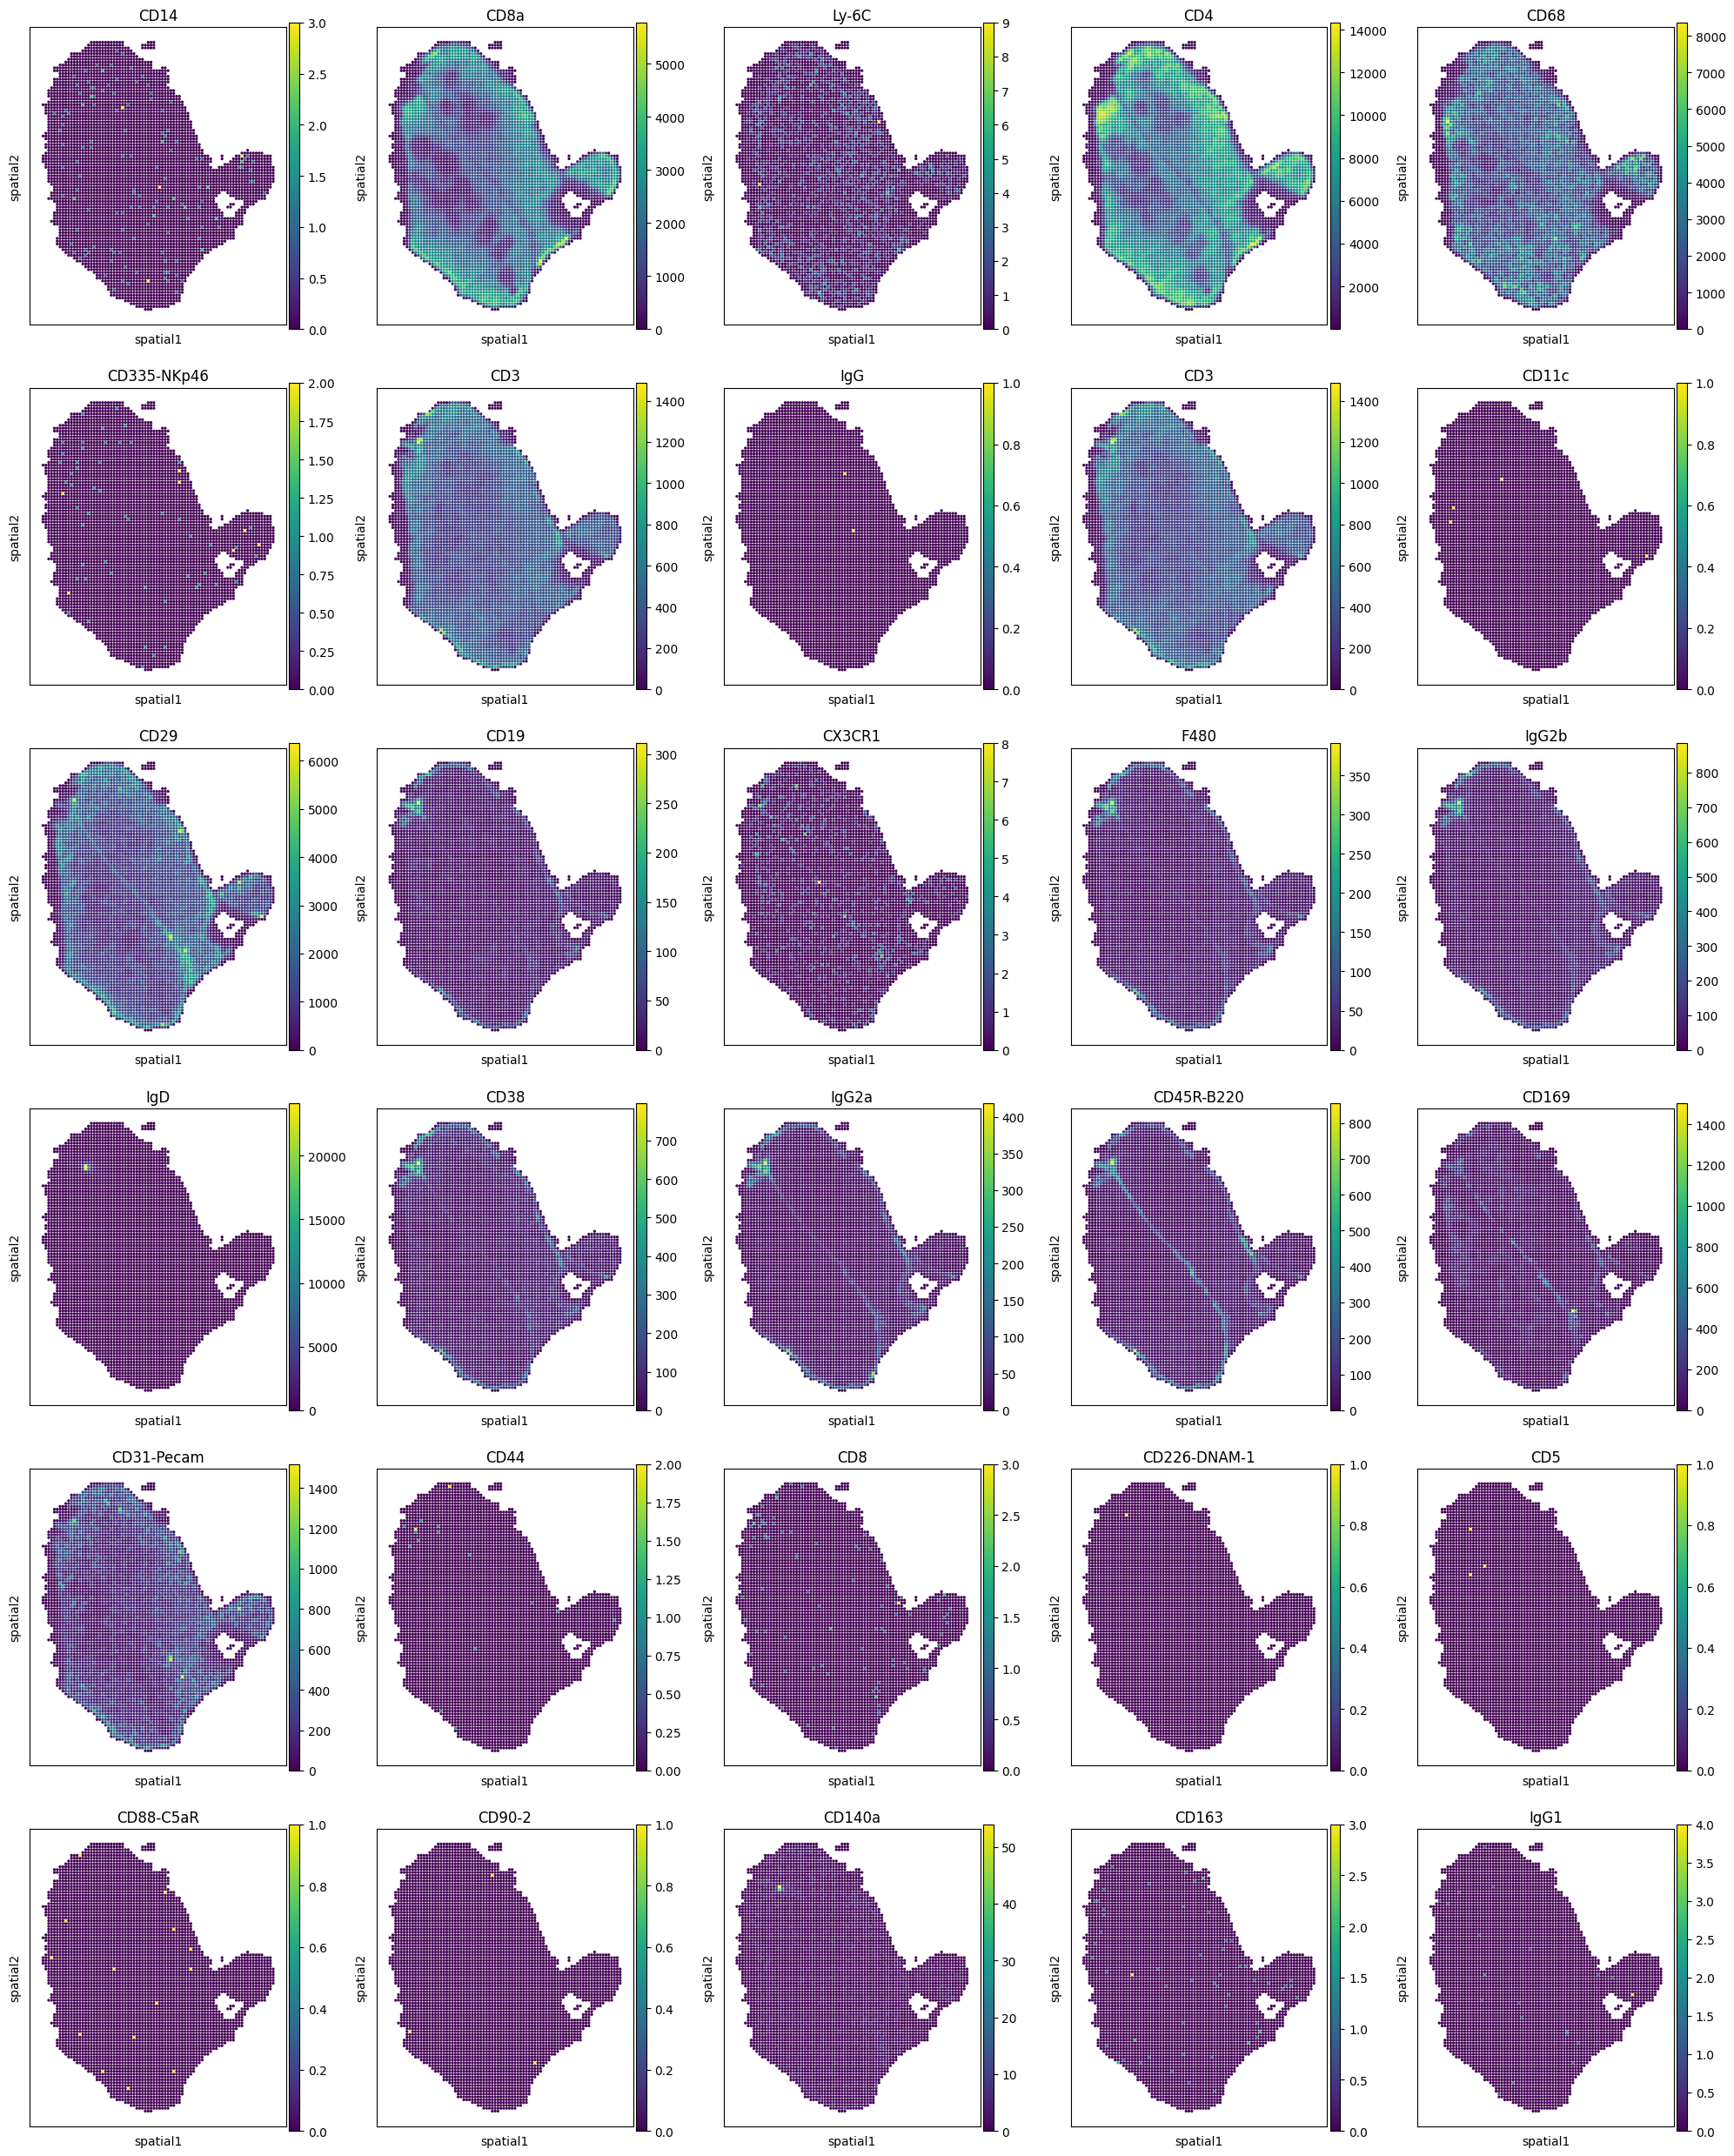

In [7]:
protein_names = np.array([
    'CD14', 'CD8a', 'Ly-6C', 'CD4', 'CD68', 'CD335-NKp46', 'CD3', 'IgG',
    'CD3', 'CD11c', 'CD29', 'CD19', 'CX3CR1', 'F480', 'IgG2b',
    'IgD', 'CD38', 'IgG2a', 'CD45R-B220', 'CD169', 'CD31-Pecam', 'CD44', 'CD8', 'CD226-DNAM-1',
    'CD5', 'CD88-C5aR', 'CD90-2', 'CD140a', 'CD163', 'IgG1'
])
protein_names_all = np.array(adata2.var_names)
protein_names_all[protein_names_all == 'Human-CD3'] = 'Human-CD3-Human'
protein_names_all[protein_names_all == 'Mouse-CD11c'] = 'Mouse-CD11c-Mouse'
protein_names_all[protein_names_all == 'Human-CD19'] = 'Human-CD19-Human'
protein_names_all[protein_names_all == 'Mouse-IgG2b'] = 'Mouse-IgG2b-Mouse'
protein_names_all[protein_names_all == 'Human-CD163'] = 'Human-CD163-Human'
protein_names_all[protein_names_all == 'Human-CD3'] = 'Human-CD3-Human'
protein_names_all[protein_names_all == 'Rat-IgG2a'] = 'Rat-IgG2a-Rat'
print()
protein_names_all = np.array([name.split('-', 1)[1] for name in protein_names_all])
adata2.var_names = protein_names_all
fig, axes = plt.subplots(6, 5, figsize=(20, 25))
axes = axes.flatten()
for i, protein in enumerate(protein_names):
    sc.pl.spatial(adata2, color=protein, ax=axes[i], show=False, title=protein, spot_size=100)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()